# DTW ver

In [38]:
import os
import sys
import numpy as np
import librosa
from numba import jit
import matplotlib.pyplot as plt
from matplotlib import patches

import libfmp.b
import libfmp.c3
import libfmp.c7

In [39]:
file_1 = "concalma_daddyyankeesnow.wav"
file_2 = "informer_snow.wav"
directory = "songs"

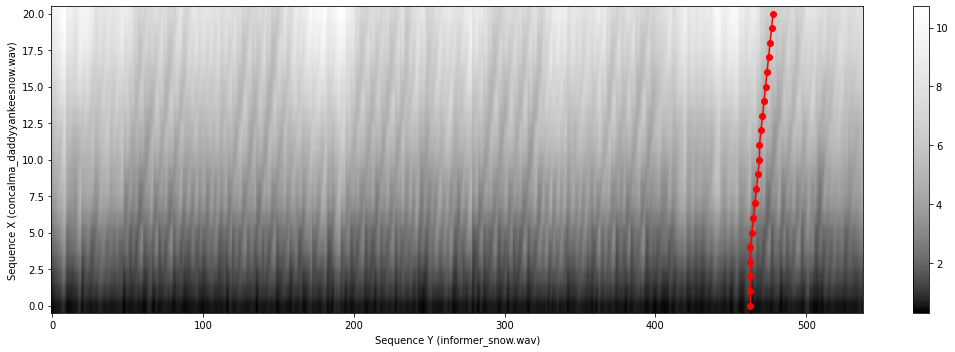

In [40]:
Fs = 22050
N_feat = 4410
H_feat = 2205

data_dir = "songs"
fn1 = os.path.join(data_dir, file_1)
fn2 = os.path.join(data_dir, file_2)

x1, Fs = librosa.load(fn1, sr=Fs)
x2, Fs = librosa.load(fn2, sr=Fs)
start = int(30*Fs)
duration = int(10*Fs)
x1 = x1[start: start+duration] # 10 seconds
C1 = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=None, hop_length=H_feat, n_fft=N_feat) # 12 chroma bins
C2 = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=None, hop_length=H_feat, n_fft=N_feat)

X, Fs_cens = libfmp.c7.compute_cens_from_chromagram(C1, ell=21, d=5)
Y, Fs_cens = libfmp.c7.compute_cens_from_chromagram(C2, ell=21, d=5)
N, M = X.shape[1], Y.shape[1]

C_FMP = libfmp.c3.compute_cost_matrix(X, Y, 'euclidean')
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D_librosa, P_librosa = librosa.sequence.dtw(C=C_FMP, step_sizes_sigma=sigma, subseq=True, 
                                            backtrack=True)
P_librosa = P_librosa[::-1, :]
# plot
cmap = libfmp.b.compressed_gray_cmap(alpha=-10, reverse=True)
fig, ax = plt.subplots(figsize=(15, 5))
# title='LibROSA implementation with step size condition $\Sigma=\{(1, 0), (0, 1), (1, 1)\}$'
libfmp.c3.plot_matrix_with_points(D_librosa, P_librosa, ax=[ax], cmap=cmap, 
                                  xlabel=f'Sequence Y ({file_2})', ylabel=f'Sequence X ({file_1})', 
                                  # title=title,
                                  marker='o', linestyle='-')
plt.tight_layout()

In [51]:
np.shape(C1)

(12, 101)

In [41]:
print(N, M)

21 538


In [50]:
np.shape(Y)

(12, 538)

In [42]:
np.shape(C_FMP)

(21, 538)

In [44]:
import IPython.display as ipd
# ipd.Audio(data=y, rate=sr)

In [59]:
# Subsequence DTW
Delta_DTW = D_librosa[-1, :] / N 
a_ast = P_librosa[0, 1]
b_ast = P_librosa[-1, 1]

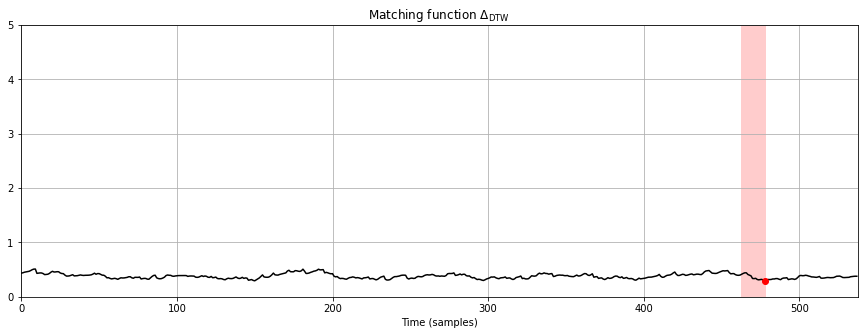

In [61]:
fig, ax = plt.subplots(figsize=(15, 5))
libfmp.b.plot_signal(Delta_DTW, ax=ax, xlabel='Time (samples)', ylabel='', ylim=[0, 5],
                     title=r'Matching function $\Delta_\mathrm{DTW}$', color='k')
ax.set_xlim([-0.5, len(Delta)-0.5])
ax.grid()
ax.plot(b_ast, Delta_DTW[b_ast], 'ro')
ax.add_patch(patches.Rectangle((a_ast-0.5, 0), b_ast-a_ast+1, 7, facecolor='r', alpha=0.2))